In [1]:
from __future__ import absolute_import
from __future__  import division
from __future__ import print_function
import tensorflow as tf
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import os

In [5]:
fights_train = np.zeros((700, 40, 160, 160, 3), dtype=np.float)
labels_train = []

In [3]:
def capture(filename):
    frames = np.zeros((40, 160, 160, 3), dtype=np.float)
    i=0
    vc = cv2.VideoCapture(filename)
    if vc.isOpened():
        rval , frame = vc.read()
    else:
        rval = False
    #frm = cv2.resize(frame,(200,200))
    frm = resize(frame,(160, 160, 3))
    frm = np.expand_dims(frm,axis=0)
    if(np.max(frm)>1):
        frm = frm/255.0
    frames[i][:] = frm
    i +=1
    while i < 40:
        rval, frame = vc.read()
        #print(i)
        #plt.imshow(frame)
        #plt.show()
        #frm = cv2.resize(frame,(200,200))
        frm = resize(frame,(160, 160, 3))
        frm = np.expand_dims(frm,axis=0)
        if(np.max(frm)>1):
            frm = frm/255.0
        frames[i][:] = frm
        i +=1
        #print(frame)
    return frames

def cut_save(main_dir,mod):
    i = 0
    #fights = np.zeros((399, 40, 200, 200, 3), dtype=np.float)
    #noFights = np.zeros((599, 42, 200, 200, 3), dtype=np.float)
    for x in os.listdir(main_dir):
        if 1 == 1:
            td = main_dir+x+'/'
            #for y in os.listdir(main_dir+x+'/'):
                #print(y)
            for file in os.listdir(td):
                fl = os.path.join(td, file)
                videos = capture(fl)
                if mod == 'train':
                    fights_train[i][:][:] = videos
                    i +=1
                    if x =='fights':
                        labels_train.append(1)
                    else:
                        labels_train.append(0)
                elif mod =='test':
                    fights_test[i][:][:] = videos
                    i +=1
                    if x =='fights':
                        labels_test.append(1)
                    else:
                        labels_test.append(0)
                elif mod =='val':
                    fights_val[i][:][:] = videos
                    i +=1
                    if x =='fights':
                        labels_val.append(1)
                    else:
                        labels_val.append(0)

In [7]:
cut_save('./trainm/',"train")

In [8]:
fights_train.shape

(700, 40, 160, 160, 3)

In [4]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, fights_test, y_train, labels_test = train_test_split(fights_train,labels_train, test_size=0.33, random_state=42)

In [ ]:
fights_train = []

In [6]:
fights_test= np.zeros((300, 40, 160, 160, 3), dtype=np.float)
labels_test = []

In [7]:
cut_save('./testm/',"test")

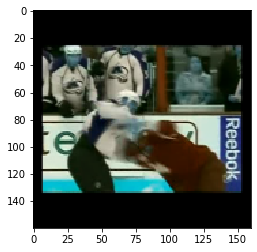

In [8]:
plt.imshow(fights_test[19][5])
plt.show()

In [10]:
layers = tf.keras.layers
models = tf.keras.models
losses = tf.keras.losses
optimizers = tf.keras.optimizers 
metrics = tf.keras.metrics
utils = tf.keras.utils
callbacks = tf.keras.callbacks
layers = tf.keras.layers
models = tf.keras.models
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
losses = tf.keras.losses
optimizers = tf.keras.optimizers 
metrics = tf.keras.metrics
utils = tf.keras.utils
callbacks = tf.keras.callbacks

plot_model = tf.keras.utils.plot_model

In [11]:
np.random.seed(1234)
num_classes = 2

In [12]:
np.random.seed(1234)
num_classes = 2
vg19 = tf.keras.applications.vgg19.VGG19
base_model = vg19(include_top=False,weights='imagenet',input_shape=(160, 160,3))
# Freeze the layers except the last 4 layers
for layer in base_model.layers:
    layer.trainable = False
# Check the trainable status of the individual layers
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [13]:
num_classes = 2

cnn = models.Sequential()
cnn.add(base_model)
cnn.add(layers.Flatten())
#cnn.add(layers.Dense(1024, activation='relu'))
#cnn.add(layers.Dropout(0.3))
#cnn.add(layers.Dense(512, activation='relu'))
#cnn.add(layers.Dropout(0.3))
#cnn.add(layers.LSTM(40))

# define LSTM model
model = models.Sequential()

model.add(layers.TimeDistributed(cnn,  input_shape=(40, 160, 160, 3)))
model.add(layers.LSTM(40 , return_sequences=True))

#model.add(layers.Dense(num_classes, activation="sigmoid"))
#model.add(layers.Dropout(0.3))

model.add(layers.TimeDistributed(layers.Dense(160, activation='relu')))

model.add(layers.GlobalAveragePooling1D(name="globale"))

'''
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
'''
model.add(layers.Dense(num_classes, activation="sigmoid" , name="last"))

adam = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.load_weights('mamon98777.hdf5')
rms = optimizers.RMSprop()
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 40, 12800)         20024384  
_________________________________________________________________
lstm (LSTM)                  (None, 40, 40)            2054560   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 160)           6560      
_________________________________________________________________
globale (GlobalAveragePoolin (None, 160)               0         
_________________________________________________________________
last (Dense)                 (None, 2)                 322       
Total params: 22,085,826
Trainable params: 2,061,442
Non-trainable params: 20,024,384
_________________________________________________________________


In [32]:

class AccuracyHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

history = AccuracyHistory()
earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=8,min_delta=1e-5, verbose=0, mode='min')
mcp_save = callbacks.ModelCheckpoint('mamon98777.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = callbacks.ReduceLROnPlateau(monitor='val_loss',patience=1, verbose=2,factor=0.5,min_lr=0.0000001)


In [33]:
batch_size =3
epochs = 10

In [34]:
y_train = utils.to_categorical(labels_train)
print(y_train)

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


In [14]:
y_test = utils.to_categorical(labels_test)
print(y_test)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 

In [36]:
import time
millis = int(round(time.time() * 1000))
print("started at " , millis)

model.fit(fights_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(fights_test, y_test),callbacks=[earlyStopping, mcp_save, reduce_lr_loss,history])

#0.8995 4

started at  1542478315557
Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - 200s 286ms/step - loss: 0.3792 - acc: 0.8643 - val_loss: 0.2605 - val_acc: 0.9233
Epoch 2/10
700/700 [==============================] - 201s 287ms/step - loss: 0.2232 - acc: 0.9243 - val_loss: 0.1652 - val_acc: 0.9467
Epoch 3/10
700/700 [==============================] - 201s 288ms/step - loss: 0.1790 - acc: 0.9500 - val_loss: 0.1335 - val_acc: 0.9533
Epoch 4/10
700/700 [==============================] - 200s 286ms/step - loss: 0.1319 - acc: 0.9600 - val_loss: 0.1083 - val_acc: 0.9733
Epoch 5/10
700/700 [==============================] - 199s 284ms/step - loss: 0.1051 - acc: 0.9750 - val_loss: 0.1849 - val_acc: 0.9350
Epoch 6/10
700/700 [==============================] - 199s 284ms/step - loss: 0.0871 - acc: 0.9736 - val_loss: 0.1137 - val_acc: 0.9583

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 7/10
700/700 [===========

In [19]:
fights_test = []

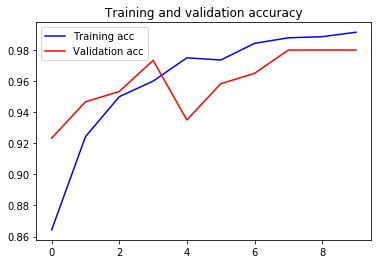

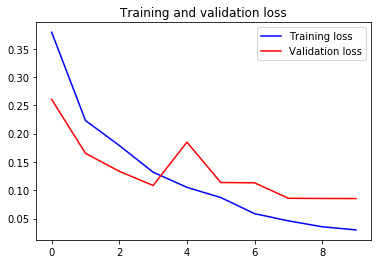

In [37]:
acc = history.acc
val_acc = history.val_acc
loss = history.loss
val_loss = history.val_loss
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [20]:
fights_train = []

In [15]:
score = model.evaluate(fights_test, y_test, batch_size=3)
score


300/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.08618128929287196, 0.98]

In [16]:
from sklearn.metrics import classification_report, confusion_matrix


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [18]:
Y_pred = model.predict(fights_test , batch_size=1)

In [19]:
yprd = Y_pred > 0.5
yprd

array([[False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [ True, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [Fal

In [20]:
ypredicted = []
for zero,one in yprd:
    if zero == True:
        ypredicted.append(0)
    else:
        ypredicted.append(1) 

In [21]:
ypredicted

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [23]:
y_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [24]:
y = []

for zero,one in y_test:
    if zero == True:
        y.append(0)
    else:
        y.append(1) 

In [25]:
confusion = confusion_matrix(y,ypredicted)
confusion.shape

(2, 2)

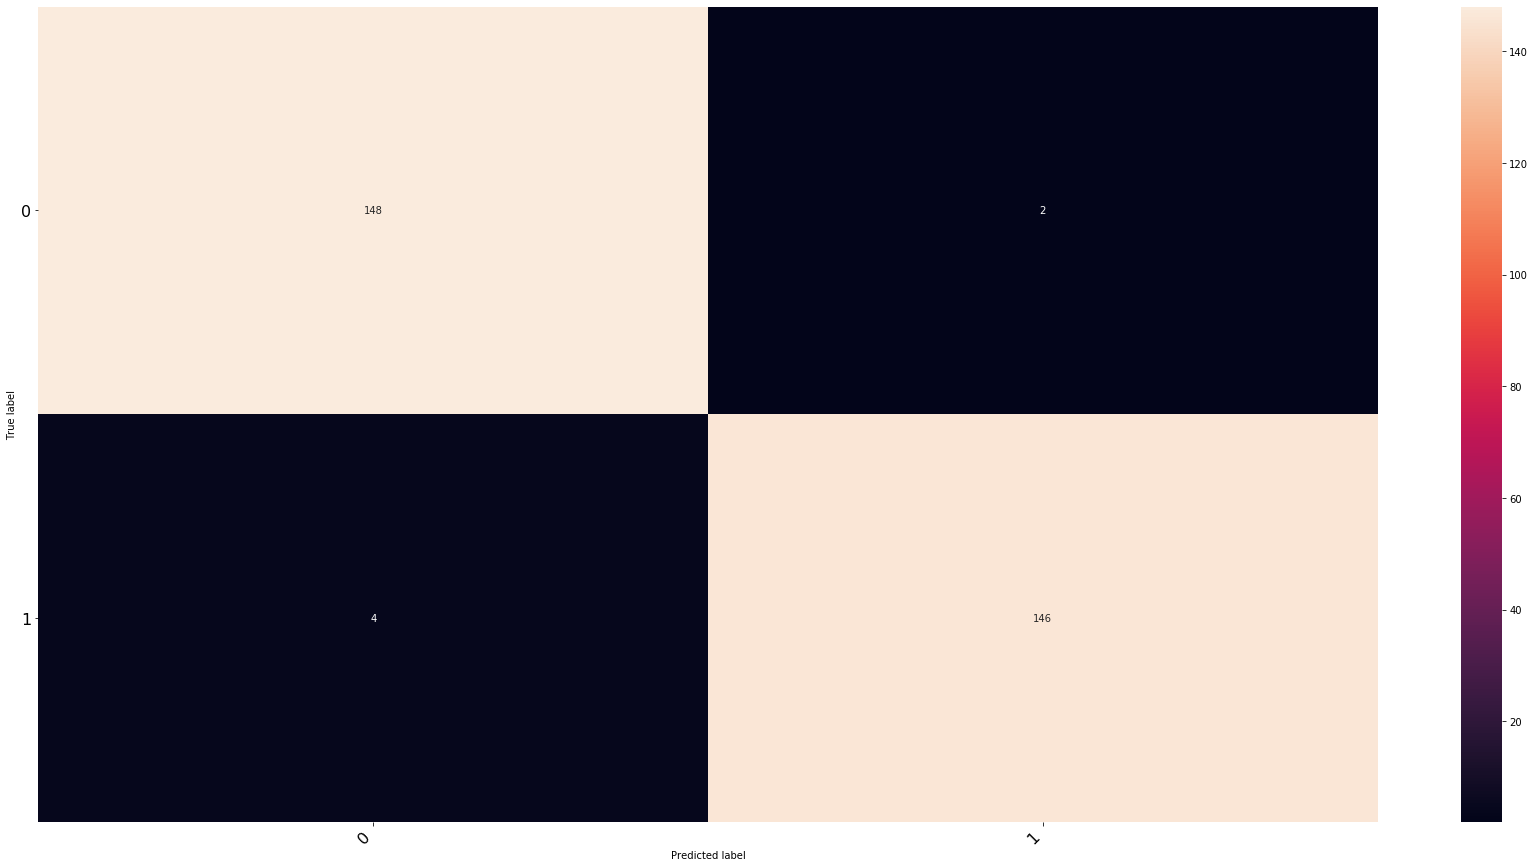

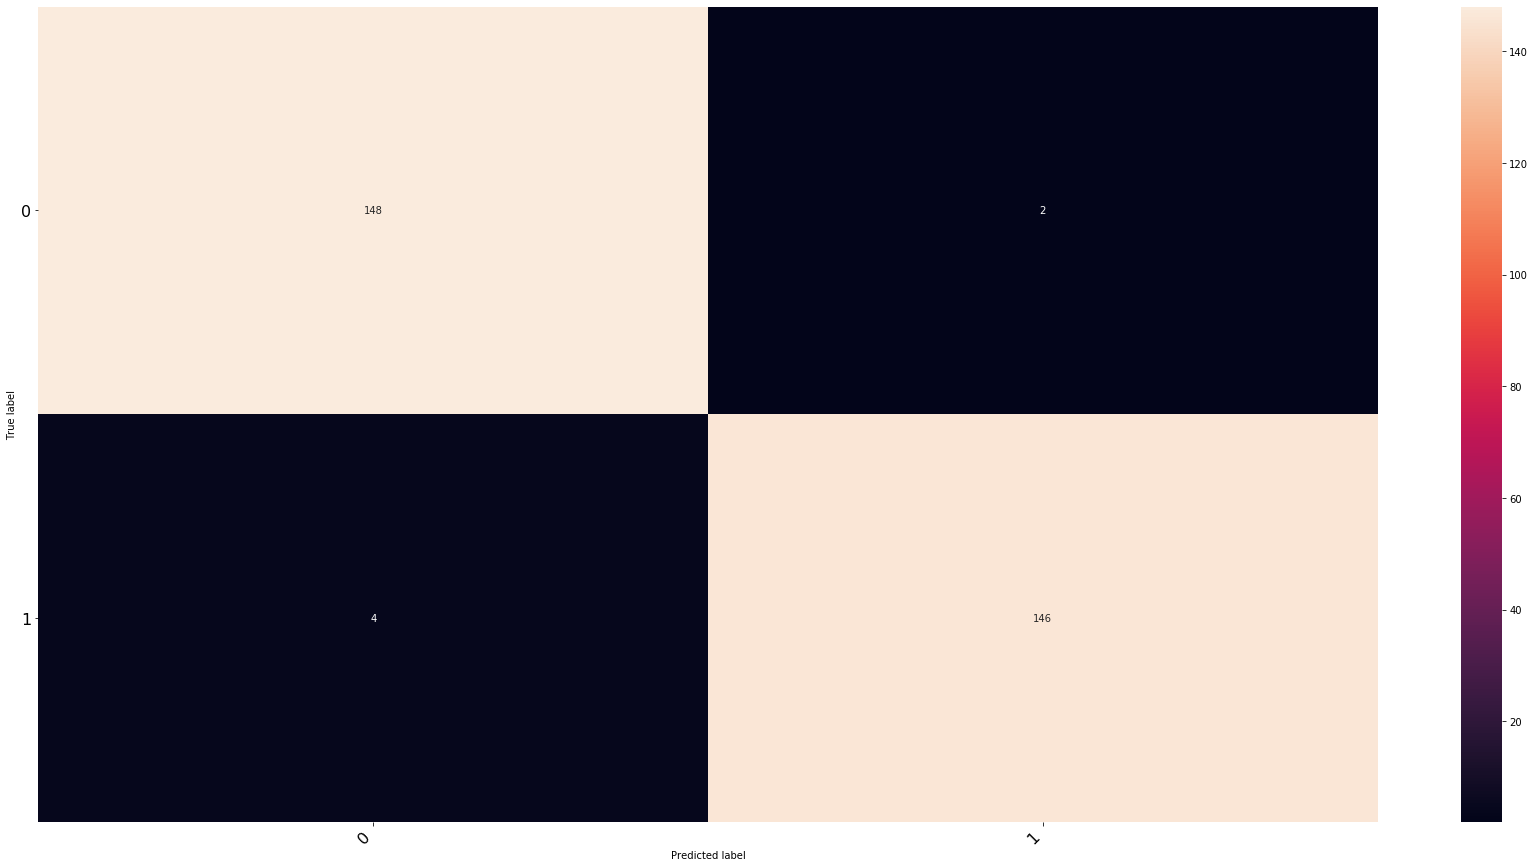

In [26]:
print_confusion_matrix(confusion, [0,1], figsize = (30,15), fontsize=16)

In [27]:
print('Classification Report')
print(classification_report(y, ypredicted, target_names=['no-violance','violance']))

Classification Report
              precision    recall  f1-score   support

 no-violance       0.97      0.99      0.98       150
    violance       0.99      0.97      0.98       150

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [39]:
model.save("mamonbest980hocky.hdfs")